In [1]:
import os
import pickle
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, gridspec, pyplot as plt

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
RESULTS_PATH = '..\\results'
FIGURE_PATH = '..\\figures'

STAGES = ['AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']
CHANNELS = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3 ', 'P4',
            'O1', 'O2 ', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']
FEATURES = ['PSD_delta', 'PSD_theta', 'PSD_alpha', 'PSD_sigma', 'PSD_beta', 'PSD_low gamma',
            'SpecShanEn', 'SampEn', 'SpecSampEn', 'PermEn', 'SpecPermEn']

delete_features = ['PSD_alpha', 'PSD_beta', 'PSD_low gamma', 'PermEn']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
importances = {}
scores = {}
feature_names = {}

for stage in STAGES:
    with open(os.path.join(RESULTS_PATH, f'new_score_rf{CAF_DOSE}', f'specpermen_importances-{stage}.pickle'), 'rb') as file:
        importances[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, f'new_score_rf{CAF_DOSE}', f'specpermen_scores-{stage}.pickle'), 'rb') as file:
        scores[stage] = pickle.load(file)
    with open(os.path.join(RESULTS_PATH, f'new_score_rf{CAF_DOSE}', f'specpermen_feature_names-{stage}.pickle'), 'rb') as file:
        feature_names[stage] = pickle.load(file)
    
    '''
    feature_categories = [name.split('-')[0] for name in feature_names[stage]]
    for delete in delete_features:
        keep_mask = delete != np.array(feature_categories)
        
        for i in range(len(importances[stage])):
            importances[stage][i] = importances[stage][i][keep_mask]
        feature_names[stage] = feature_names[stage][keep_mask]

        feature_categories = [category for category in feature_categories if delete != category]
    '''

In [5]:
importance_means = {}
importance_stds = {}
for stage in STAGES:
    importance_means[stage] = np.mean(importances[stage], axis=0)
    importance_stds[stage] = np.std(importances[stage], axis=0)

score_means = {}
score_stds = {}
for stage in STAGES:
    score_means[stage] = np.mean(scores[stage])
    score_stds[stage] = np.std(scores[stage])

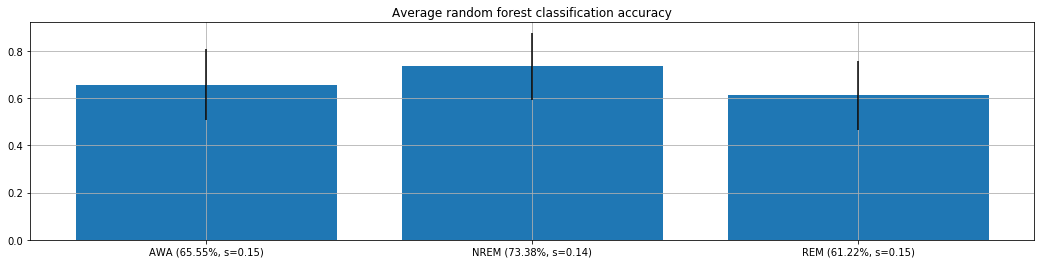

In [6]:
plt.figure(figsize=(18, 4))
plt.title('Average random forest classification accuracy')
plt.bar(np.arange(len(score_means)), score_means.values(), yerr=score_stds.values())
plt.xticks(np.arange(len(score_means)), [stage.replace('AWSL', 'AWA') + f' ({acc*100:.2f}%, s={std:.2f})' for stage, acc, std in zip(STAGES, score_means.values(), score_stds.values())])
plt.grid()
plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', 'multiFeatureRF-accuracy'), dpi=400)
plt.show()

In [13]:
'''
feature_colors = {
    'PSD_delta': '#FF0000',
    'PSD_theta': '#FF2B00',
    'PSD_alpha': '#FF5600',
    'PSD_sigma': '#FF8100',
    'PSD_beta': '#FFAC00',
    'PSD_low gamma': '#FFD700',
    'SpecShanEn': '#00FFFF',
    'SampEn': '#00C9FF',
    'SpecSampEn': '#0099FF',
    'PermEn': '#005EFF'
}
'''
feature_colors = {
    'PSD_delta': '#FF0000',
    'PSD_theta': '#FF2B00',
    'PSD_alpha': '#FF5600',
    'PSD_sigma': '#FF8100',
    'PSD_beta': '#FFAC00',
    'PSD_low gamma': '#FFD700',
    'SpecShanEn': '#00FFFF',
    'SampEn': '#00C9FF',
    'SpecSampEn': '#0099FF',
    'PermEn': '#005EFF',
    'SpecPermEn': '#0028FF'
}
'''
feature_colors = {
    'PSD_delta': '#FF0000',
    'PSD_theta': '#F06000',
    'PSD_alpha': '#E2B500',
    'PSD_sigma': '#A9D400',
    'PSD_beta': '#4FC600',
    'PSD_low gamma': '#00B800',
    'SpecShanEn': '#00BDBD',
    'SampEn': '#009ACD',
    'SpecSampEn': '#006FDE',
    'PermEn': '#003BEE',
    'SpecPermEn': '#0000FF'
}
'''

"\nfeature_colors = {\n    'PSD_delta': '#FF0000',\n    'PSD_theta': '#F06000',\n    'PSD_alpha': '#E2B500',\n    'PSD_sigma': '#A9D400',\n    'PSD_beta': '#4FC600',\n    'PSD_low gamma': '#00B800',\n    'SpecShanEn': '#00BDBD',\n    'SampEn': '#009ACD',\n    'SpecSampEn': '#006FDE',\n    'PermEn': '#003BEE',\n    'SpecPermEn': '#0000FF'\n}\n"

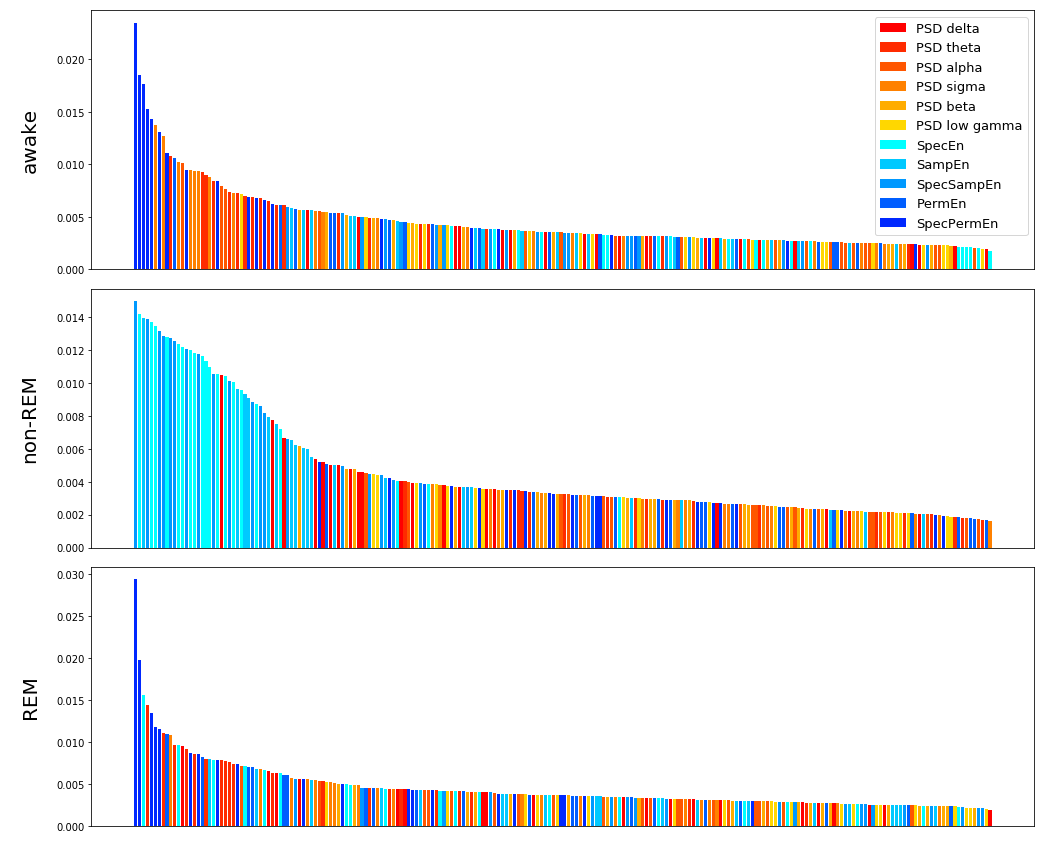

In [17]:
fontsize_big = 20
fontsize_small = 13

# create gridspec
gs = gridspec.GridSpec(len(STAGES), 2, width_ratios=[0.065, 1], wspace=0, hspace=0.075)
subplot_index = 0
plt.figure(figsize=(18, 15))

for stage in STAGES:
    # add current stage annotation
    plt.subplot(gs[subplot_index])
    subplot_index += 1
    plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                 xy=(0, 0.5),
                 va='center',
                 ha='center',
                 fontsize=fontsize_big,
                 rotation=90)
    plt.axis('off')
    
    plt.subplot(gs[subplot_index])
    subplot_index += 1
    
    # get sorted indices for the importances
    indices = np.argsort(importance_means[stage])[::-1]
    
    # plot bars for each feature
    for category in FEATURES:
        mask = [category in name for name in feature_names[stage][indices]]
        if np.sum(mask) > 0:
            name = category.replace('_', ' ').replace('Shan', '')
            
            # plot bars of current feature
            plt.bar(np.arange(len(indices))[mask],
                    importance_means[stage][indices][mask],
                    label=name,
                    color=feature_colors[category])#,
                    #yerr=importance_stds[stage][indices][mask],
                    #error_kw=dict(lw=3, capsize=0, capthick=0, alpha=0.3))
    
    plt.xticks([])
    if stage == STAGES[0]:
        plt.legend(fontsize=fontsize_small)

plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', f'multiFeatureRF-bars'),
            bbox_inches='tight',
            transparent=True,
            dpi=200)
plt.show()

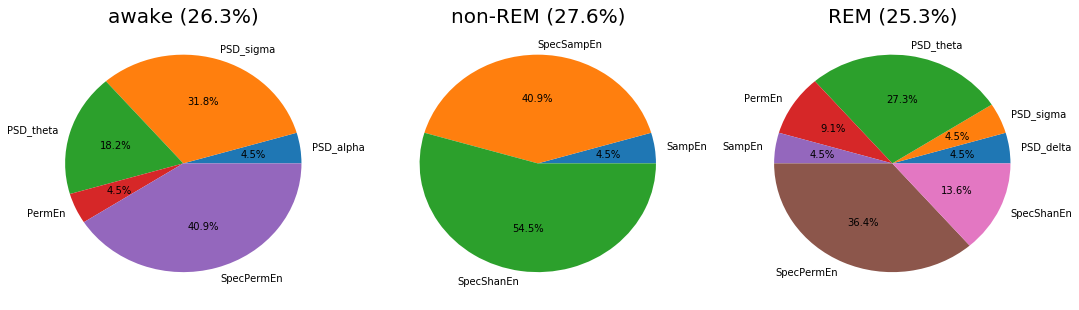

In [9]:
plt.figure(figsize=(18, 5))

for i, stage in enumerate(STAGES):
    indices = np.argsort(importance_means[stage])[::-1][:int(len(importance_means[stage])*0.1)]
    occurences = [name.split('-')[0] for name in feature_names[stage][indices]]
    shares = np.array([[feature, occurences.count(feature)] for feature in np.unique(occurences)])
    
    total = importance_means[stage][indices].sum() / importance_means[stage].sum()
    
    plt.subplot(1, 3, i + 1)
    plt.title(f'{stage.replace("AWSL", "awake").replace("NREM", "non-REM")} ({total*100:.1f}%)', fontsize=20)
    plt.pie(shares[:,1], labels=shares[:,0], autopct=lambda x: f'{x:.1f}%')

plt.show()

In [10]:
print('Maximal feature importance')
for stage in STAGES:
    max_value = importance_means[stage].max() / importance_means[stage].sum()
    print(f'{stage.replace("AWSL", "awake").replace("NREM", "non-REM")}: {max_value*100:.1f}%')

Maximal feature importance
awake: 2.3%
non-REM: 1.5%
REM: 2.9%


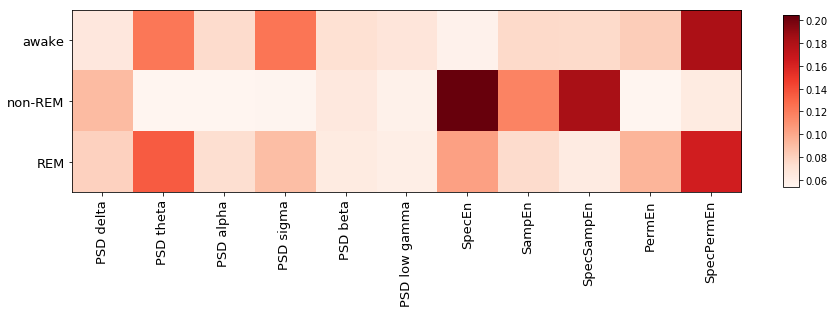

In [11]:
fontsize_small = 13
fontsize_big = 20

# get feature categories, remove duplicate elements from list while preserving order
seen = set()
seen_add = seen.add
feature_categories = [name.split('-')[0] for name in feature_names[STAGES[0]] if not (name.split('-')[0] in seen or seen_add(name.split('-')[0]))]

# sum up importance means
matrix = np.empty((len(STAGES), len(feature_categories)))
for i, stage in enumerate(STAGES):
    for j, category in enumerate(feature_categories):
        mask = [category == name.split('-')[0] for name in feature_names[stage]]
        matrix[i,j] = np.sum(importance_means[stage][mask])

# get feature names
names = []
for name in feature_categories:
    name = name.replace('_', ' ').replace('Shan', '')
    names.append(name)
        
plt.figure(figsize=(15, 6))
# plot importance matrix
plt.imshow(matrix, cmap='Reds')

# set x- and y-ticks
plt.xticks(np.arange(len(feature_categories)), names, rotation=90, fontsize=fontsize_small)
plt.yticks(np.arange(len(STAGES)),
           [stage.replace('AWSL', 'awake').replace('NREM', 'non-REM') for stage in STAGES],
           fontsize=fontsize_small)

# add colorbar
plt.colorbar(shrink=0.525, aspect=11)

plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', 'multiFeatureRF-matrix'),
            bbox_inches='tight',
            transparent=True,
            dpi=200)
plt.show()

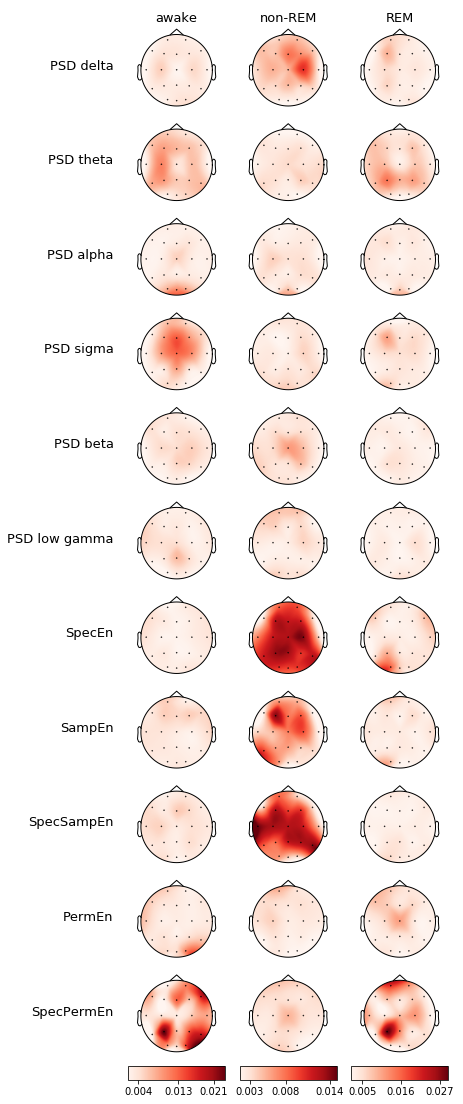

In [16]:
fontsize_small = 13
fontsize_big = 20
colormap = 'Reds'

# groups feature importances by feature
importance = {}
for stage in STAGES:
    mean = importance_means[stage].reshape((-1, 20))
    features = [name.split('-')[0] for name in feature_names[stage][::20]]
    importance[stage] = dict([(feature, curr) for feature, curr in zip(features, mean)])

width = len(STAGES)
height = len(importance[STAGES[0]])

# create gridspec
gs = gridspec.GridSpec(height + 2,
                       width + 1,
                       width_ratios=[0.001] + [1] * width,
                       height_ratios=[0.01] + [1] * height + [0.175])
subplot_counter = 1
#plt.figure(figsize=(6, 12)) # poster version
plt.figure(figsize=(6, 18)) # full version

# add stage annotations
for stage in STAGES:
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                 xy=(0.5, 0),
                 ha='center',
                 va='top',
                 fontsize=fontsize_small)
    plt.axis('off')

vmin = {}
vmax = {}
feature_labels = []
for feature in importance[STAGES[0]].keys():
    # add feature name annotations
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    
    name = feature.replace('_', ' ').replace('SpecShanEn', 'SpecEn')
    feature_labels.append(plt.annotate(name,
                                       xy=(1, 0.5),
                                       ha='right',
                                       va='center',
                                       fontsize=fontsize_small))
    plt.axis('off')
    
    axes = []
    for stage in STAGES:
        axes.append(plt.subplot(gs[subplot_counter]))
        subplot_counter += 1
        
        # get min and max value for plots and colormaps
        vmin[stage] = np.min([np.min(importance[stage][ft]) for ft in importance[STAGES[0]].keys()])
        vmax[stage] = np.max([np.max(importance[stage][ft]) for ft in importance[STAGES[0]].keys()])
        
        # plot topomaps
        viz.plot_topomap(importance[stage][feature],
                         sensor_pos,
                         vmin=vmin[stage],
                         vmax=vmax[stage],
                         cmap=colormap,
                         contours=False,
                         show=False)

# add colorbars
subplot_counter += 1
for stage in STAGES:
    norm = colors.Normalize(vmin=vmin[stage],vmax=vmax[stage])
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=plt.subplot(gs[subplot_counter]), orientation='horizontal')
    # set colorbar ticks
    cbar.set_ticks([round(vmin[stage] + val * (vmax[stage] - vmin[stage]), 3) for val in [0.1, 0.5, 0.9]])
    subplot_counter += 1
    
plt.savefig(os.path.join(FIGURE_PATH, f'randomForest{CAF_DOSE}', f'multiFeatureRF'),
            bbox_inches='tight',
            bbox_extra_artists=feature_labels,
            transparent=True,
            dpi=200)
plt.show()